<a href="https://colab.research.google.com/github/AlejandrodelaConcha/Deep-Learning/blob/master/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for NLP - Project

In [0]:
import io
import os
import numpy as np
import scipy
import scipy.linalg
import re
import string

In [3]:
##### Clon Git-Hub to have access to the sentences to valuate.
!git clone https://github.com/AlejandrodelaConcha/Deep-Learning.git

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 70 (delta 4), reused 27 (delta 3), pack-reused 30
Unpacking objects: 100% (70/70), done.


In [0]:
PATH_TO_SENTENCES = '/content/Deep-Learning/HWK2/data/'
PATH_TO_VECTORS='/content/'

In [0]:
##### The following sections aim to download the word embeddings located in my drive
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link="https://drive.google.com/drive/folders/1i7JxoJKXtaRNISqS6mOhAMh-w1T0GWMo?usp=sharing"
id="1i7JxoJKXtaRNISqS6mOhAMh-w1T0GWMo"

In [7]:
folder_id = '1i7JxoJKXtaRNISqS6mOhAMh-w1T0GWMo'
lister = drive.ListFile({'q': "'%s' in parents" % folder_id}).GetList()
for item in lister:
    print(item['title'])
    # this should tell you which mimetype the file you're trying to download 
    # has. 
    print('title: %s, mimeType: %s' % (item['title'], item['mimeType']))
    mimetypes = {
        # Drive Document files as PDF
        'application/vnd.google-apps.document': 'application/pdf',

        # Drive Sheets files as MS Excel files.
        'application/vnd.google-apps.spreadsheet': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet'

    # see https://developers.google.com/drive/v3/web/mime-types
    }
    download_mimetype = None
    if item['mimeType'] in mimetypes:
        download_mimetype = mimetypes[item['mimeType']]
        file.GetContentFile(item['title'], mimetype=download_mimetype)

      #  item.GetContentFile(PATH_TO_DATA + item['title'], mimetype=download_mimetype)
    else: 
        item.GetContentFile(item['title'])

wiki.fr.vec
title: wiki.fr.vec, mimeType: application/octet-stream
wiki.en.vec
title: wiki.en.vec, mimeType: application/octet-stream
crawl-300d-200k.vec
title: crawl-300d-200k.vec, mimeType: application/octet-stream


# 1) Monolingual (English) word embeddings 

In [0]:
import warnings
warnings.filterwarnings("ignore")

class Word2vec():
  ### Class to upload and compare word-embeddings. 
    
    def __init__(self, fname, nmax=100000):
       ## Input:
       ## fname: name of the file containing the embeddings.
       ## nmax: maximum number of words to us
        
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.word2id_lowercase = dict.fromkeys(self.word2vec_lowercase.keys())
        
        for idx,word in enumerate(self.word2id):
            self.word2id[word]=idx
            
        for idx,word in enumerate(self.word2id_lowercase):
            self.word2id_lowercase[word]=idx
       
        self.id2word = {v: k for k, v in self.word2id.items()} 
        self.id2word_lowercase= {v: k for k, v in self.word2id_lowercase.items()}  
       
        self.embeddings=np.vstack(self.word2vec.values())
        self.embeddings_lowercase=np.vstack(self.word2vec_lowercase.values())
    
    def load_wordvec(self, fname, nmax):
      ##### Function to load the word-embeddings 
      ## Input:
      ## fname: name of the file containing the embeddings.
      ## nmax: maximum number of words to use 
        self.word2vec = {}
        self.word2vec_lowercase={}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                word_lower=word.lower()
                if(word_lower not in self.word2vec_lowercase.keys()):
                    self.word2vec_lowercase[word_lower] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5,lowercase=False):
        ##### Function computing the 5 most similar words to word w
        ## Input:
        # w: Word of reference 
        # K: number of closest neighbors
        # lowercase: whether or not use the lowecased embeddings 
        
        if(lowercase):
            scores=np.array([self.score(w,x,lowercase) for x in self.id2word_lowercase.values()])
            k_index=np.argsort(-scores)[:K]
            k_similar=np.array([self.id2word_lowercase[i] for i in k_index])
        else:          
            scores=np.array([self.score(w,x,lowercase) for x in self.id2word.values()])
            k_index=np.argsort(-scores)[:K]
            k_similar=np.array([self.id2word[i] for i in k_index])
        return k_similar

    def score(self, w1, w2,lowercase=False):
        ### Function computing the similarity between two word vectors
        ## Input: 
        # w1,w2: words to compare 
        # lowercase: whether or not use the lowecased embeddings 
        
        if(lowercase):
            v1=self.embeddings_lowercase[self.word2id_lowercase[w1.lower()]]
            v2=self.embeddings_lowercase[self.word2id_lowercase[w2.lower()]]
        else:
            v1=self.embeddings[self.word2id[w1]]
            v2=self.embeddings[self.word2id[w2]]
        score=v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        return score

class Word2vec_faster():
    ##### Class to load the word-embeddings  and process in a faster way that the propossed one 
     
    def __init__(self, fname, nmax=100000):
       ## Input:
       ## fname: name of the file containing the embeddings.
       ## nmax: maximum number of words to us
      
        self.load_wordvec(fname, nmax)
        self.vocabulary=np.array([w for w in self.word2vec.keys()])
    
    def load_wordvec(self, fname, nmax):
      ##### Function to load the word-embeddings 
      ## Input:
      ## fname: name of the file containing the embeddings.
      ## nmax: maximum number of words to use 
      
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word_lower=word.lower()
                if(word_lower not in self.word2vec.keys()):
                    self.word2vec[word_lower] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
       ##### Function computing the 5 most similar words to word w
        ## Input:
        # w: Word of reference 
        # K: number of closest neighbors 
              
        scores=np.array([self.score(w,x) for x in self.word2vec.keys()])
        k_index=np.argsort(-scores)[:K]
        k_similar=self.vocabulary[k_index]
        return k_similar

    def score(self, w1, w2):
        ### Function computing the similarity between two word vectors
        ## Input: 
        # w1,w2: words to compare 
        
        v1=self.word2vec[w1.lower()]
        v2=self.word2vec[w2.lower()]
        score=v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        return score

In [0]:
w2v = Word2vec(os.path.join(PATH_TO_VECTORS, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
print("     Results sensitive to lower and upper case")
for w1, w2 in zip(('cat', 'dog', 'dogs', 'Paris', 'Germany'), ('dog', 'pet', 'cats', 'France', 'Berlin')):
    print("Distances between wordvectors: ",w1, w2, w2v.score(w1, w2,lowercase=False))
for w1 in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print("Five nearest neighbors of ",w1)
    print(w2v.most_similar(w1,lowercase=False))

Loaded 25000 pretrained word vectors
     Results sensitive to lower and upper case
Distances between wordvectors:  cat dog 0.671683666279249
Distances between wordvectors:  dog pet 0.6842064029669219
Distances between wordvectors:  dogs cats 0.7074389328052404
Distances between wordvectors:  Paris France 0.7058595452409975
Distances between wordvectors:  Germany Berlin 0.7060253015336013
Five nearest neighbors of  cat
['cat' 'cats' 'kitty' 'kitten' 'Cat']
Five nearest neighbors of  dog
['dog' 'dogs' 'puppy' 'Dog' 'canine']
Five nearest neighbors of  dogs
['dogs' 'dog' 'Dogs' 'puppies' 'cats']
Five nearest neighbors of  Paris
['Paris' 'Parisian' 'France' 'Versailles' 'Lyon']
Five nearest neighbors of  Germany
['Germany' 'Austria' 'Bavaria' 'Berlin' 'Munich']


In [0]:
print("     Results not sensitive to lower and upper case")
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print("Distances between wordvectors",w1, w2, w2v.score(w1, w2,lowercase=True))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print("Five nearest neighbors of ",w1)
    print(w2v.most_similar(w1,lowercase=True))

     Results not sensitive to lower and upper case
Distances between wordvectors cat dog 0.671683666279249
Distances between wordvectors dog pet 0.6842064029669219
Distances between wordvectors dogs cats 0.7074389328052404
Distances between wordvectors paris france 0.7058595452409975
Distances between wordvectors germany berlin 0.7060253015336013
Five nearest neighbors of  cat
['cat' 'cats' 'kitten' 'dog' 'kittens']
Five nearest neighbors of  dog
['dog' 'dogs' 'puppy' 'canine' 'pup']
Five nearest neighbors of  dogs
['dogs' 'dog' 'puppies' 'cats' 'canine']
Five nearest neighbors of  paris
['paris' 'parisian' 'france' 'versailles' 'lyon']
Five nearest neighbors of  germany
['germany' 'austria' 'bavaria' 'berlin' 'munich']


In [0]:
class BoV():
  #### Class to create embedding from a list of sentences and stimate the similarity between them
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        ### Function to create an embedding of a list of sentences. 
        ## Input.
        ## sentences: list of sentences.
        ## idf: wheter use the idf-weighted mean of word vectors or the sample mean
 
        sentemb = []
        # variables for preprocessing
        # puntuation
        punct = string.punctuation.replace('-', '').replace("'",'')
        # regex to match intra-word dashes and intra-word apostrophes
        my_regex = re.compile(r"(\b[-']\b)|[\W_]")
        for sent in sentences:
            
            sent = re.sub('\s+', ' ', sent)
             # remove punctuation
            sent = ''.join(l for l in sent if l not in punct)
             # remove dashes that are not intra-word
            sent = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), sent)
            # strip extra white space
            sent= re.sub(' +',' ',sent)
            # strip leading and trailing white space
            sent= sent.strip()
            words = sent.split(' ')
            words_in_vocabulary=[w for w in words if w in self.w2v.word2vec.keys()]
            if(len(words_in_vocabulary)>0):
                if idf is False:
            
                    aux_sentemb=[self.w2v.word2vec[w] for w in words_in_vocabulary]
                    sentemb.append(sum(aux_sentemb)/float(len(aux_sentemb)))
                
                else:
                # idf-weighted mean of word vectors
                    aux_sentemb=[self.w2v.word2vec[w] for w in words_in_vocabulary if w in idf.keys()]
                    weigths=[idf[w] for w in words_in_vocabulary if w in idf.keys()]
                    multiplication=[intem1*item2 for intem1,item2 in zip(aux_sentemb,weigths)]
                    sentemb.append(sum(multiplication)/sum(weigths))
            else:
                sentemb.append(np.repeat(np.inf,300))

        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        ### Function finding the K closest sentences to s 
        ## s: sentences of reference
        ## sentences: list of sentences
        ## idf: wheter use the idf-weighted mean of word vectors or the sample mean
        ## K: number of closest neighbors 
        
        keys = self.encode(sentences, idf)
        
        query = self.encode([s], idf)
        scores= [query.dot(key)/(np.linalg.norm(query)*np.linalg.norm(key)) for key in keys]
        scores=np.hstack(scores)
        k_index=np.argsort(-scores)[:K]
        k_similar=np.array([sentences[i] for i in k_index])
        print(k_similar)
        return k_similar

    def score(self, s1, s2, idf=False):
         ### Function computing the similarity between two sentences.
        ## Input: 
        # s1,s2: sentences to compare.
        # idf: whether or not use the idf to create the sentence embedding. 
        
        v1=self.encode([s1],idf)
        v2=self.encode([s2],idf)
        score=float(v1.dot(v2.T))/(np.linalg.norm(v1)*np.linalg.norm(v2))
        return score
    
    def build_idf(self, sentences):
        ### Function to compute the idf score of the sentences in a given list.
        ## sntences: list of sentences
        
        idf = {}
        # variables for preprocessing
        # puntuation
        punct = string.punctuation.replace('-', '').replace("'",'')
        # regex to match intra-word dashes and intra-word apostrophes
        my_regex = re.compile(r"(\b[-']\b)|[\W_]")
        for sent in sentences:
             # remove formatting
            sent = re.sub('\s+', ' ', sent)
             # remove punctuation
            sent = ''.join(l for l in sent if l not in punct)
             # remove dashes that are not intra-word
            sent = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), sent)
            # strip extra white space
            sent= re.sub(' +',' ',sent)
            # strip leading and trailing white space
            sent= sent.strip()
            words = sent.split(' ')
            for w in set(words):
                idf[w] = idf.get(w, 0) + 1         
        for w in idf.keys():
            idf[w]=max(1, np.log10(float(len(sentences))/float(idf[w])))
        
        return idf

In [10]:
##### Packages for preprocessing
import re
import string

w2v = Word2vec_faster(os.path.join(PATH_TO_VECTORS, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
fname=os.path.join(PATH_TO_SENTENCES, 'sentences.txt')
sentences=io.open(fname, encoding='utf-8')
sentences=[sent for sent in sentences]

# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

print("5 closest sentences according to the mean sentence embedding to: ",sentences[10])
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean

print(" Distance between sentences ", sentences[7]," and ",sentences[13]," :", s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))
 

Loaded 19765 pretrained word vectors
5 closest sentences according to the mean sentence embedding to:  1 smiling african american boy . 

['1 smiling african american boy . \n'
 'an african american man smiling . \n'
 'a little african american boy and girl looking up . \n'
 'a girl in black hat holding an african american baby . \n'
 "an african american woman braiding another african american woman 's hair , while sitting in a white chair . \n"]
 Distance between sentences  1 man singing and 1 man playing a saxophone in a concert . 
  and  10 people venture out to go crosscountry skiing . 
  : 0.5390759564194053


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

## 1 - Download and load 50k first vectors of
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec

https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

In [11]:
w2v_fr= Word2vec(os.path.join(PATH_TO_VECTORS, 'wiki.fr.vec'), nmax=50000)
w2v_en= Word2vec(os.path.join(PATH_TO_VECTORS, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


## 2 - Get words that appear in both vocabs (= identical character strings)

Use it to create the matrix X and Y (of aligned embeddings for these words)

In [0]:
common_words = [w for w in w2v_en.word2vec.keys() if w in w2v_fr.word2vec.keys()]
X=np.vstack([w2v_fr.word2vec[w] for w in common_words]).T
Y=np.vstack([w2v_en.word2vec[w] for w in common_words]).T

## 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
Now W*French_vector is in the same space as English_vector


In [0]:
U,_,Vh=scipy.linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

## 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)


In [0]:

def projector(word,W_fr_to_en,w2v_origin_language,language_to_project="en"):
  ### Function proyecting a word living in a language space to another one. (Translation)
  ## Input:
  ## word: word to proyect 
  ## W_fr_to_en: proyection matrix.
  ## w2v_origin_language: embeddings of the language in which the word is written.
  ## language_to_project: language space in which the word will be translated
  
    if language_to_project=="english":
        fr_embedding=w2v_origin_language.word2vec[word]
        new_embedding=W.dot(fr_embedding)
    if language_to_project=="french":
        en_embedding=w2v_origin_language.word2vec[word]
        new_embedding=W.T.dot(en_embedding)
    return(new_embedding)
        
def nearest_neighbors(K,word,W_fr_to_en,w2v_origin_language,w2v_objective_language,language_to_project="english",method="euclidian"):
    vocabulary=np.array([w for w in w2v_objective_language.word2vec.keys()])
    embedding=projector(word,W_fr_to_en,w2v_origin_language,language_to_project)
    if method=="euclidian":
        dist=np.array([np.linalg.norm(embedding-x) for x in w2v_objective_language.word2vec.values()])
        k_index=np.argsort(dist)[:K]
        k_nearest=vocabulary[k_index]
    if method=="cosine":
        score=np.array([embedding.dot(x)/(np.linalg.norm(embedding)*np.linalg.norm(x)) for x in w2v_objective_language.word2vec.values()])
        k_index=np.argsort(-score)[:K]
        k_nearest=vocabulary[k_index]
    print(str(K)+"-nearest neighbors of "+word+" using the "+method+" method in the "+language_to_project+" space")
    print(k_nearest)
    
##### Traduction of "chat" in English 
nearest_neighbors(5,"chat",W,w2v_fr,w2v_en,language_to_project="english",method="euclidian")
nearest_neighbors(5,"chat",W,w2v_fr,w2v_en,language_to_project="english",method="cosine")  

##### Traduction of "chien" in English 
nearest_neighbors(5,"chien",W,w2v_fr,w2v_en,language_to_project="english",method="euclidian")
nearest_neighbors(5,"chien",W,w2v_fr,w2v_en,language_to_project="english",method="cosine")  

##### Traduction of "vache" in English 
nearest_neighbors(5,"vache",W,w2v_fr,w2v_en,language_to_project="english",method="euclidian")
nearest_neighbors(5,"vache",W,w2v_fr,w2v_en,language_to_project="english",method="cosine") 

##### Traduction of "man" in French
nearest_neighbors(5,"man",W,w2v_en,w2v_fr,language_to_project="french",method="euclidian")
nearest_neighbors(5,"man",W,w2v_en,w2v_fr,language_to_project="french",method="cosine")

##### Traduction of "woman" in French
nearest_neighbors(5,"woman",W,w2v_en,w2v_fr,language_to_project="french",method="euclidian")
nearest_neighbors(5,"woman",W,w2v_en,w2v_fr,language_to_project="french",method="cosine")

##### Traduction of "king" in French
nearest_neighbors(5,"king",W,w2v_en,w2v_fr,language_to_project="french",method="euclidian")
nearest_neighbors(5,"king",W,w2v_en,w2v_fr,language_to_project="french",method="cosine")

5-nearest neighbors of chat using the euclidian method in the english space
['cat' 'rabbit' 'dog' 'kittens' 'kitten']
5-nearest neighbors of chat using the cosine method in the english space
['cat' 'rabbit' 'hamster' 'feline' 'poodle']
5-nearest neighbors of chien using the euclidian method in the english space
['dog' 'dogs' 'poodle' 'rabbit' 'puppy']
5-nearest neighbors of chien using the cosine method in the english space
['dog' 'poodle' 'terrier' 'dogs' 'spaniel']
5-nearest neighbors of vache using the euclidian method in the english space
['cow' 'cows' 'goat' 'chickens' 'milk']
5-nearest neighbors of vache using the cosine method in the english space
['cow' 'cows' 'bovine' 'goat' 'milk']
5-nearest neighbors of man using the euclidian method in the french space
['man' ',' '»' 'ainsi' 'et']
5-nearest neighbors of man using the cosine method in the french space
['man' 'woman' 'men' 'boy' 'stranger']
5-nearest neighbors of woman using the euclidian method in the french space
['femme' '

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

## 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

In [0]:
train_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.train')
train_file=io.open(train_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in train_file]
Y_train=[line[0] for line in lines]
X_train=[line[1] for line in lines]

dev_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.dev')
dev_file=io.open(dev_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in dev_file]
Y_dev=[line[0] for line in lines]
X_dev=[line[1] for line in lines]

test_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.test.X')
test_file=io.open(test_file, encoding='utf-8')
X_test=[line for line in test_file]

## 2 - Encode sentences with the BoV model above

In [13]:

##### Packages for preprocessing
import re
import string
punct = string.punctuation.replace('-', '').replace("'",'')

##### Encoding
w2v = Word2vec_faster(os.path.join(PATH_TO_VECTORS, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)
idf_train = {} if False else s2v.build_idf(X_train)
idf_dev = {} if False else s2v.build_idf(X_dev)
idf_test = {} if False else s2v.build_idf(X_test)
embeddings_train=s2v.encode(X_train,idf_train)
embeddings_dev=s2v.encode(X_dev,idf_dev)
embeddings_test=s2v.encode(X_test,idf_test)

Loaded 19765 pretrained word vectors


## 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn (consider tuning the L2 regularization on the dev set)

In [14]:

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

#### Eliminate sentences that were not embedded
index_to_keep_train=[x[0] for x in embeddings_train]
index_to_keep_train=np.where(np.isfinite(index_to_keep_train)==True)[0].tolist()
embeddings_to_keep_train=np.vstack([embeddings_train[x] for x in index_to_keep_train])
Y_to_keep_train=np.hstack([Y_train[x] for x in index_to_keep_train])

index_to_keep_dev=[x[0] for x in embeddings_dev]
index_to_keep_dev=np.where(np.isfinite(index_to_keep_dev)==True)[0].tolist()
embeddings_to_keep_dev=np.vstack([embeddings_dev[x] for x in index_to_keep_dev])
Y_to_keep_dev=np.hstack([Y_dev[x] for x in index_to_keep_dev])

results_LogisticRegression=LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial',C=0.5)
results_LogisticRegression.fit(embeddings_to_keep_train,Y_to_keep_train)

print('Accuracy in train set', results_LogisticRegression.score(embeddings_to_keep_train,Y_to_keep_train))
print('Accuracy in dev set', results_LogisticRegression.score(embeddings_to_keep_dev,Y_to_keep_dev))

Accuracy in train set 0.46796526636939684
Accuracy in dev set 0.410535876475931


## 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).

In [0]:

index_to_keep_test=[x[0] for x in embeddings_test]
index_to_keep_test=np.where(np.isfinite(index_to_keep_test)==True)[0].tolist()
embeddings_to_keep_test=np.vstack([embeddings_test[x] for x in index_to_keep_test])

predictions=np.repeat(2,len(embeddings_test))
predictions[index_to_keep_test]=results_LogisticRegression.predict(embeddings_to_keep_test)

path_output=os.path.join(PATH_TO_SENTENCES,'logreg_bov_y_test_sst.txt')
lines = '\n'.join([str(p) for p in predictions])
with open(path_output,'w') as f:
    f.writelines(lines)

In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)


#################### I also tried RandomForest and XGBoost, but they got an accuracy of 0.36421435059 and  0.380563124432 
#### in the dev set. For making this notebook more readeble I just kept SVM with the rbf kernel experiments.
### Nevertheless the results were not better in the dev set when compared with the logistic regression.

#### Eliminate sentences that were not embedded
index_to_keep_train=[x[0] for x in embeddings_train]
index_to_keep_train=np.where(np.isfinite(index_to_keep_train)==True)[0].tolist()
embeddings_to_keep_train=np.vstack([embeddings_train[x] for x in index_to_keep_train])
Y_to_keep_train=np.hstack([Y_train[x] for x in index_to_keep_train])

index_to_keep_dev=[x[0] for x in embeddings_dev]
index_to_keep_dev=np.where(np.isfinite(index_to_keep_dev)==True)[0].tolist()
embeddings_to_keep_dev=np.vstack([embeddings_dev[x] for x in index_to_keep_dev])
Y_to_keep_dev=np.hstack([Y_dev[x] for x in index_to_keep_dev])

#### I use CV to choose the best parameters for the model 

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
scoring = {'Accuracy': make_scorer(accuracy_score)}


results_SVMrbf=svm.SVC(kernel='rbf',C=1,gamma=0.1)
results_SVMrbf.fit(embeddings_to_keep_train,Y_to_keep_train)

print('Accuracy in train set', results_SVMrbf.score(embeddings_to_keep_train,Y_to_keep_train))
print('Accuracy in dev set', results_SVMrbf.score(embeddings_to_keep_dev,Y_to_keep_dev))

##Save results
index_to_keep_test=[x[0] for x in embeddings_test]
index_to_keep_test=np.where(np.isfinite(index_to_keep_test)==True)[0].tolist()
embeddings_to_keep_test=np.vstack([embeddings_test[x] for x in index_to_keep_test])

predictions=np.repeat(2,len(embeddings_test))
predictions[index_to_keep_test]=results_SVMrbf.predict(embeddings_to_keep_test)

path_output=os.path.join(PATH_TO_SENTENCES,'SVMrbf_bov_y_test_sst.txt')
lines = '\n'.join([str(p) for p in predictions])
with open(path_output,'w') as f:
    f.writelines(lines)


Accuracy in train set 0.46878666979582256
Accuracy in dev set 0.3960036330608538


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [15]:
import keras

Using TensorFlow backend.


In [0]:
# 1 - Load train/dev/test sets of SST
train_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.train')
train_file=io.open(train_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in train_file]
Y_train=[line[0] for line in lines]
X_train=[line[1] for line in lines]

dev_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.dev')
dev_file=io.open(dev_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in dev_file]
Y_dev=[line[0] for line in lines]
X_dev=[line[1] for line in lines]

test_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.test.X')
test_file=io.open(test_file, encoding='utf-8')
X_test=[line for line in test_file]

In [0]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import text_to_word_sequence,one_hot
from keras.utils import to_categorical

clean_sentences=[text_to_word_sequence(sent) for sent in (X_train+X_test+X_dev)]
vocabulary=set(np.hstack(clean_sentences))
vocab_size = len(vocabulary)

Y_train_ones=to_categorical(Y_train)
Y_dev_ones=to_categorical(Y_dev)

X_train_one_hot=[one_hot(sent,vocab_size) for sent in X_train]
X_test_one_hot=[one_hot(sent,vocab_size) for sent in X_test]
X_dev_one_hot=[one_hot(sent,vocab_size) for sent in X_dev]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

X_train_DL = pad_sequences(X_train_one_hot, maxlen=40)
X_dev_DL = pad_sequences(X_dev_one_hot, maxlen=40)
X_test_DL= pad_sequences(X_test_one_hot,maxlen=40)

## 4.2 - Design and train your model

In [0]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout,Bidirectional

embed_dim  = 50 # word embedding dimension
nhid       = 15 # number of hidden units in the LSTM
vocab_size = len(vocabulary) # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.3))
model.add(LSTM(nhid, dropout_W=0.3, dropout_U=0.3))
model.add(Dense(n_classes, activation='sigmoid'))

In [34]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'Adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          891950    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                3960      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 80        
Total params: 895,990
Trainable params: 895,990
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 32
n_epochs = 5

history = model.fit(X_train_DL, Y_train_ones, batch_size=bs, epochs=n_epochs, validation_data=(X_dev_DL, Y_dev_ones))


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5759 - acc: 0.2658 - val_loss: 1.5643 - val_acc: 0.2707
Epoch 2/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.5179 - acc: 0.3264 - val_loss: 1.5198 - val_acc: 0.3388
Epoch 3/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.3695 - acc: 0.4079 - val_loss: 1.4786 - val_acc: 0.3724
Epoch 4/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.1923 - acc: 0.4858 - val_loss: 1.5051 - val_acc: 0.3760
Epoch 5/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.0552 - acc: 0.5588 - val_loss: 1.5978 - val_acc: 0.3806


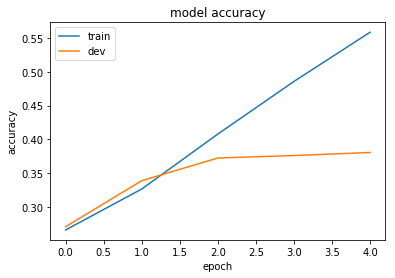

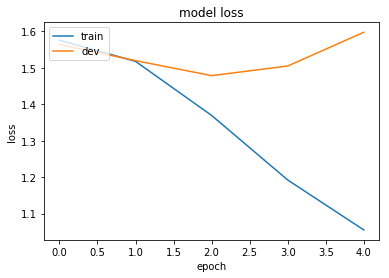

Accuracy in train set= 0.6549625468164794
Accuracy in dev set= 0.38056312443233425


In [36]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
import matplotlib.pyplot as plt
%matplotlib inline

f = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')

plt.show()
f.savefig("Accuracy.pdf", bbox_inches='tight')


# Graphs performance algorithm
f = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
f.savefig("Loss.pdf", bbox_inches='tight')


prediction_dev = model.predict(X_dev_DL)
prediction_dev=[str(np.argmax(x)) for x in prediction_dev]
prediction_train = model.predict(X_train_DL)
prediction_train=[str(np.argmax(x)) for x in prediction_train]
prediction_test = model.predict(X_test_DL)
prediction_test=[str(np.argmax(x)) for x in prediction_test]

print ('Accuracy in train set= ' + str(accuracy_score(Y_train,prediction_train)))
print ('Accuracy in dev set= '+ str(accuracy_score(Y_dev,prediction_dev)))


predictions=model.predict(X_test_DL)
predictions=[np.argmax(x) for x in predictions]
path_output=os.path.join(PATH_TO_SENTENCES,'logreg_lstm_y_test sst.txt')
lines = '\n'.join([str(p) for p in predictions])
with open(path_output,'w') as f:
    f.writelines(lines)


## 4.3 -- innovate !

Loaded 19765 pretrained word vectors
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 19s 2ms/step - loss: 1.5336 - acc: 0.3104 - val_loss: 1.4209 - val_acc: 0.3706
Epoch 2/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.4079 - acc: 0.3727 - val_loss: 1.3630 - val_acc: 0.3706
Epoch 3/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.3635 - acc: 0.3830 - val_loss: 1.3318 - val_acc: 0.3751
Epoch 4/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.3377 - acc: 0.3998 - val_loss: 1.3347 - val_acc: 0.3760
Epoch 5/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.3122 - acc: 0.4094 - val_loss: 1.2963 - val_acc: 0.4242
Epoch 6/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.2940 - acc: 0.4238 - val_loss: 1.2927 - val_acc: 0.4205
Epoch 7/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.2741 - acc: 0.4371 - val_l

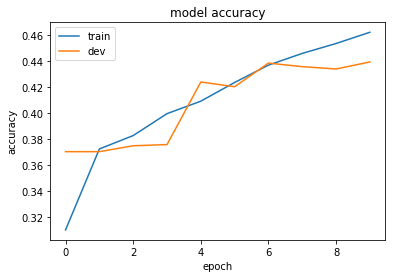

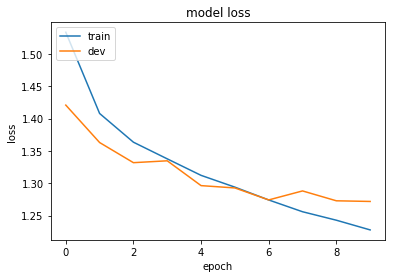

In [38]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Activation,Bidirectional,Flatten
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.metrics import accuracy_score

###### Uploading data
## Upload Word_Embeddings
w2v = Word2vec_faster(os.path.join(PATH_TO_VECTORS, 'crawl-300d-200k.vec'), nmax=25000) ## put attention to use the right class


## Uplad Dataset
train_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.train')
train_file=io.open(train_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in train_file]
Y_train=[line[0] for line in lines]
X_train=[line[1] for line in lines]

dev_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.dev')
dev_file=io.open(dev_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in dev_file]
Y_dev=[line[0] for line in lines]
X_dev=[line[1] for line in lines]

test_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.test.X')
test_file=io.open(test_file, encoding='utf-8')
X_test=[line for line in test_file]


##### Preprocessing

### Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
index_to_word = dict((v,k) for k,v in word_index.items())
vocab_size=len(word_index)+1

### One hot encoding

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_dev = tokenizer.texts_to_sequences(X_dev)
sequences_test= tokenizer.texts_to_sequences(X_test)

X_dev_DL_2 = pad_sequences(sequences_dev, maxlen=40)
X_train_DL_2= pad_sequences(sequences_train, maxlen=40)
X_test_DL_2= pad_sequences(sequences_test, maxlen=40)

Y_train_ones=to_categorical(Y_train)
Y_dev_ones=to_categorical(Y_dev)

### Create matrix with pretrained embeddings
embedding_matrix = np.zeros((vocab_size,300))
for word, i in word_index.items():
    embedding_vector = w2v.word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Model definition
embed_dim  = 300 # word embedding dimension
nhid       = 50 # number of hidden units in the LSTM
vocab_size = len(word_index)+1 # size of the vocabulary
n_classes  = 5
n_reduction=150

model_2 = Sequential()
model_2.add(Embedding(vocab_size,embed_dim,weights=[embedding_matrix],
                            input_length=40,trainable=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(n_reduction,activation="relu"))
model_2.add(Bidirectional(LSTM(nhid, dropout_W=0.3, dropout_U=0.3)))
model_2.add(Dense(n_classes, activation='sigmoid'))


### Model fitting

loss_classif     =  'categorical_crossentropy' 
optimizer        =  'Adam' 
metrics_classif  =  ['accuracy']

model_2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('LSTM_2.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)
bs = 64
n_epochs = 10

history_2 = model_2.fit(X_train_DL_2, Y_train_ones, batch_size=bs, epochs=n_epochs, validation_data=(X_dev_DL_2, Y_dev_ones),callbacks = [checkpoint])

###### Model evaluation


import matplotlib.pyplot as plt
%matplotlib inline

prediction_dev = model_2.predict(X_dev_DL_2)
prediction_dev=[str(np.argmax(x)) for x in prediction_dev]
prediction_train = model_2.predict(X_train_DL_2)
prediction_train=[str(np.argmax(x)) for x in prediction_train]
prediction_test = model_2.predict(X_test_DL_2)
prediction_test=[str(np.argmax(x)) for x in prediction_test]

print ('Accuracy in train set= ' + str(accuracy_score(Y_train,prediction_train)))
print ('Accuracy in dev set= '+ str(accuracy_score(Y_dev,prediction_dev)))

# Graphs
f = plt.figure()
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')

plt.show()
f.savefig("Accuracy_2.pdf", bbox_inches='tight')

f = plt.figure()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
f.savefig("Loss_2.pdf", bbox_inches='tight')

# File

path_output=os.path.join(PATH_TO_SENTENCES,"LSTM_PRETRAINEMBEDDING_y_test_sst.txt")
lines = '\n'.join([str(p) for p in prediction_test])
with open(path_output,'w') as f:
    f.writelines(lines)             
      

I will try to improve the performance of the algorithm by adding a attention mechanism to the network. As this component is not defined in keras by default, I should implement it myself.

In [0]:
import keras.backend as K
from keras.layers import Layer
from keras import initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    initially taken from: https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Note: The layer has been tested with Keras 2.0.6
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    #### Aqui se definen las variables que seran entrenadas en el modelo.
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        ### Esta linea siempre se debe poner al final para indicar como se va a construir el modelo
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    ############ Esta es la function donde se hacen todas las operaciones del layer.
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

Loaded 19765 pretrained word vectors
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 20s 2ms/step - loss: 1.5023 - acc: 0.3250 - val_loss: 1.3814 - val_acc: 0.3642
Epoch 2/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.3540 - acc: 0.3888 - val_loss: 1.3434 - val_acc: 0.3706
Epoch 3/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.3257 - acc: 0.3942 - val_loss: 1.3310 - val_acc: 0.3833
Epoch 4/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.3057 - acc: 0.4061 - val_loss: 1.3170 - val_acc: 0.3833
Epoch 5/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.2822 - acc: 0.4142 - val_loss: 1.3043 - val_acc: 0.4060
Epoch 6/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.2721 - acc: 0.4367 - val_loss: 1.3055 - val_acc: 0.4233
Epoch 7/10
8544/8544 [==============================] - 15s 2ms/step - loss: 1.2478 - acc: 0.4510 - val_l

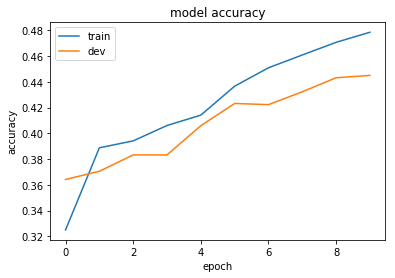

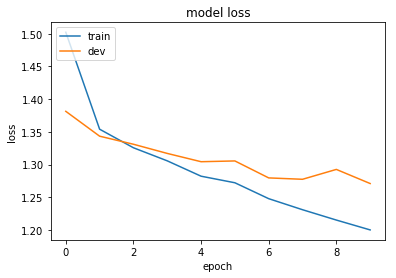

In [40]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Activation,Bidirectional,Flatten, Dropout
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.metrics import accuracy_score

###### Uploading data
## Upload Word_Embeddings
w2v = Word2vec_faster(os.path.join(PATH_TO_VECTORS, 'crawl-300d-200k.vec'), nmax=25000) ## put attention to use the right class


## Uplad Dataset
train_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.train')
train_file=io.open(train_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in train_file]
Y_train=[line[0] for line in lines]
X_train=[line[1] for line in lines]

dev_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.dev')
dev_file=io.open(dev_file, encoding='utf-8')
lines=[line.split(' ', 1) for line in dev_file]
Y_dev=[line[0] for line in lines]
X_dev=[line[1] for line in lines]

test_file=os.path.join(PATH_TO_SENTENCES, 'SST/stsa.fine.test.X')
test_file=io.open(test_file, encoding='utf-8')
X_test=[line for line in test_file]


##### Preprocessing

### Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
index_to_word = dict((v,k) for k,v in word_index.items())
vocab_size=len(word_index)+1

### One hot encoding

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_dev = tokenizer.texts_to_sequences(X_dev)
sequences_test= tokenizer.texts_to_sequences(X_test)

X_dev_DL_2 = pad_sequences(sequences_dev, maxlen=40)
X_train_DL_2= pad_sequences(sequences_train, maxlen=40)
X_test_DL_2= pad_sequences(sequences_test, maxlen=40)

Y_train_ones=to_categorical(Y_train)
Y_dev_ones=to_categorical(Y_dev)

### Create matrix with pretrained embeddings
embedding_matrix = np.zeros((vocab_size,300))
for word, i in word_index.items():
    embedding_vector = w2v.word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Model definition
embed_dim  = 300 # word embedding dimension
nhid       = 50 # number of hidden units in the LSTM
vocab_size = len(word_index)+1 # size of the vocabulary
n_classes  = 5
n_reduction=150

model_3 = Sequential()
model_3.add(Embedding(vocab_size,embed_dim,weights=[embedding_matrix],
                            input_length=40,trainable=False))
model_3.add(Dropout(0.3))
model_3.add(Dense(n_reduction,activation="relu"))
model_3.add(Bidirectional(LSTM(nhid, dropout_W=0.3, dropout_U=0.3,return_sequences=True)))
model_3.add(AttentionWithContext())
model_3.add(Dense(n_classes, activation='sigmoid'))


### Model fitting

loss_classif     =  'categorical_crossentropy' 
optimizer        =  'Adam' 
metrics_classif  =  ['accuracy']

model_3.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('LSTM_2.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)
bs = 64
n_epochs = 10

history_3 = model_3.fit(X_train_DL_2, Y_train_ones, batch_size=bs, epochs=n_epochs, validation_data=(X_dev_DL_2, Y_dev_ones),callbacks = [checkpoint])

###### Model evaluation


import matplotlib.pyplot as plt
%matplotlib inline

prediction_dev = model_3.predict(X_dev_DL_2)
prediction_dev=[str(np.argmax(x)) for x in prediction_dev]
prediction_train = model_3.predict(X_train_DL_2)
prediction_train=[str(np.argmax(x)) for x in prediction_train]
prediction_test = model_3.predict(X_test_DL_2)
prediction_test=[str(np.argmax(x)) for x in prediction_test]

print ('Accuracy in train set= ' + str(accuracy_score(Y_train,prediction_train)))
print ('Accuracy in dev set= '+ str(accuracy_score(Y_dev,prediction_dev)))

# Graphs
f = plt.figure()
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')

plt.show()
f.savefig("Accuracy_3.pdf", bbox_inches='tight')

f = plt.figure()
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
f.savefig("Loss_3.pdf", bbox_inches='tight')

# File

path_output=os.path.join(PATH_TO_SENTENCES,"LSTM_PRETRAINEMBEDDING_y_test_sst_2.txt")
lines = '\n'.join([str(p) for p in prediction_test])
with open(path_output,'w') as f:
    f.writelines(lines)             
      